# Vesuvius Challenge - Advanced Exploratory Data Analysis

This notebook provides deeper insights into the dataset, including intensity distributions, class usage, and topological structure.

In [1]:
import torch
import tifffile
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import measure
from ipywidgets import interact, IntSlider

# Check Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

DATA_DIR = Path('data')
TRAIN_IMG = DATA_DIR / 'train_images'
TRAIN_LBL = DATA_DIR / 'train_labels'

files = sorted(list(TRAIN_IMG.glob('*.tif')))
print(f"Found {len(files)} files.")

Device: cuda
Found 806 files.


## 1. Load Data
Select an index to analyze a specific scroll/volume.

In [2]:
IDX = 0  # Change this to look at different files
if len(files) > IDX:
    img_path = files[IDX]
    lbl_path = TRAIN_LBL / img_path.name
    
    print(f"Loading {img_path.name}...")
    vol = tifffile.imread(img_path)
    mask = tifffile.imread(lbl_path) if lbl_path.exists() else None
    
    print(f"Shape: {vol.shape}")
    print(f"Data Type: {vol.dtype} (Min: {vol.min()}, Max: {vol.max()})")

Loading 1004283650.tif...
Shape: (320, 320, 320)
Data Type: uint8 (Min: 0, Max: 255)


## 2. Intensity Distribution
Understanding the histogram helps in deciding normalization strategies. Does the background have a specific value?

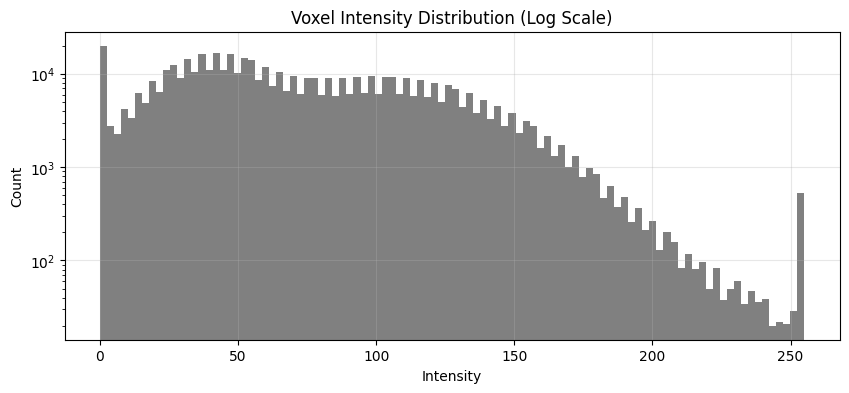

In [3]:
if 'vol' in locals():
    # Subsample for speed
    sub_vol = vol[::4, ::4, ::4].flatten()
    
    plt.figure(figsize=(10, 4))
    plt.hist(sub_vol, bins=100, color='gray', log=True)
    plt.title("Voxel Intensity Distribution (Log Scale)")
    plt.xlabel("Intensity")
    plt.ylabel("Count")
    plt.grid(True, alpha=0.3)
    plt.show()

## 3. Class Imbalance Analysis
How much of the volume is actually papyrus surface? This informs loss weighting.

In [4]:
if mask is not None:
    total_voxels = mask.size
    surface_voxels = np.count_nonzero(mask)
    ratio = surface_voxels / total_voxels
    
    print(f"Total Voxels: {total_voxels}")
    print(f"Surface Voxels: {surface_voxels}")
    print(f"Surface Percentage: {ratio*100:.4f}%")
    print(f"Background Percentage: {(1-ratio)*100:.4f}%")
    
    # Suggest pos_weight for BCE
    pos_weight = (1 - ratio) / ratio
    print(f"Suggested BCE pos_weight: {pos_weight:.2f}")

Total Voxels: 32768000
Surface Voxels: 24930279
Surface Percentage: 76.0812%
Background Percentage: 23.9188%
Suggested BCE pos_weight: 0.31


## 4. Interactive Slicing
Scroll through the 3D volume to see how the surface evolves.

In [5]:
def plot_slice(z):
    if 'vol' not in locals() or vol.ndim != 3: return
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(vol[z], cmap='gray')
    ax[0].set_title(f"CT Slice {z}")
    ax[0].axis('off')
    
    if mask is not None:
        ax[1].imshow(mask[z], cmap='gray')
        ax[1].set_title(f"Label Slice {z}")
        ax[1].axis('off')
    plt.show()

if 'vol' in locals() and vol.ndim == 3:
    interact(plot_slice, z=IntSlider(min=0, max=vol.shape[0]-1, step=1, value=vol.shape[0]//2));

interactive(children=(IntSlider(value=160, description='z', max=319), Output()), _dom_classes=('widget-interac…

## 5. Topology Check (Connected Components)
We need to know how many "sheets" are in the ground truth. Ideally, valid sheets are large connected components.
Small components might be noise/fragments.

Calculating Connected Components (this might take a moment)...
Found 7 separate connected components in Ground Truth.


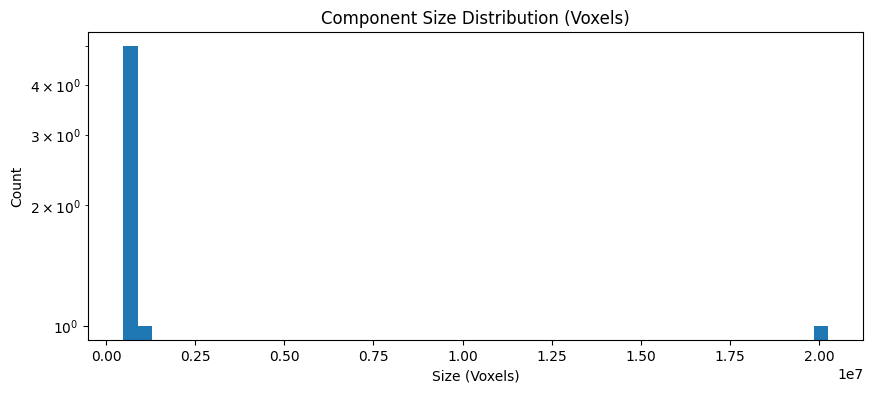

Largest 5 Components (Voxels): [np.float64(20254339.0), np.float64(1273221.0), np.float64(759580.0), np.float64(754459.0), np.float64(727243.0)]
Number of tiny artifacts (<100 voxels): 0


In [6]:
if mask is not None:
    print("Calculating Connected Components (this might take a moment)...")
    # Standard labelling (26-connectivity for 3D)
    labeled_mask, num_features = measure.label(mask, connectivity=3, return_num=True)
    print(f"Found {num_features} separate connected components in Ground Truth.")
    
    # Analyze size of components
    props = measure.regionprops(labeled_mask)
    sizes = [p.area for p in props]
    
    plt.figure(figsize=(10, 4))
    plt.hist(sizes, bins=50, log=True)
    plt.title("Component Size Distribution (Voxels)")
    plt.xlabel("Size (Voxels)")
    plt.ylabel("Count")
    plt.show()
    
    print("Largest 5 Components (Voxels):", sorted(sizes, reverse=True)[:5])
    print("Number of tiny artifacts (<100 voxels):", sum(1 for s in sizes if s < 100))